In [20]:
#Importamos librerias utiles
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math as m
#librerias para segmentado por superpixeles
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.segmentation import random_walker
#para leer las imagenes en orden alfabetico "humano"
import re
#para leer las imagenes en el path
import os
#para obtener las caracteristicas de textura 
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
from skimage.feature import local_binary_pattern as lbp
from sklearn.svm import SVC

## Lectura de las imagenes de train
Es necesario leer todas las imagenes de nuevo ya que no quiero hacer una carpeta de entrenamiento para ocupar mas memoria.

In [148]:
#funcion para convertir texto a int para ordenar las carpetas a leer
def atoi(text):
    return int(text) if text.isdigit() else text
#funcion para obtener el ordenamiento
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text)]
#creamos una lista vacia que contendra las imagenes. En cada casilla contendra un tipo de hoja, es decir.
#esta es una lista de listas
listImages = []
#iteramos sobre el path y las carpetas con os.walk
for path, dirs, files in os.walk('./mascaras'):
    #iteramos sobre las carpetas con nombre ordenado, tipo0, tipo1, tipo2, etc
    for dirnames in sorted(dirs, key=natural_keys):
        #definimos una lista auxiliar que contendra todas las imagenes de una carpeta especifica
        auxList = [cv2.imread(file,0) for file in sorted(glob.glob('mascaras/'+dirnames+'/*.png'),key=natural_keys)]
        #hacemos append de dicha lista auxiliar para obtener la lista con todas las imagenes
        #de las hojas en una casilla determinada
        listImages.append(auxList)
#convertimos la lista en arrays de numpy para que sea mas manejable
listImages = np.array(listImages)

In [7]:
#creamos una lista vacia que contendra los binarios de las imagenes. En cada casilla contendra un tipo de hoja, es decir.
#esta es una lista de listas
binarios = []
auxList = []
#iteramos sobre el path y las carpetas con os.walk
for path, dirs, files in os.walk('./binarios'):
    #iteramos sobre las carpetas con nombre ordenado, tipo0, tipo1, tipo2, etc
    for dirnames in sorted(dirs, key=natural_keys):
        #definimos una lista auxiliar que contendra todas las imagenes de una carpeta especifica
        auxList = [cv2.imread(file,0) for file in sorted(glob.glob('binarios/'+dirnames+'/*.png'),key=natural_keys)]
        #hacemos append de dicha lista auxiliar para obtener la lista con todas las imagenes
        #de las hojas en una casilla determinada
        binarios.append(auxList)
#convertimos la lista en arrays de numpy para que sea mas manejable
binarios = np.array(binarios)

In [10]:
#funcion para mostrar n imagenes
def muestraImagenes(imagen, filas, columnas):
    plt.figure(figsize = (16,16))
    for i in range (filas*columnas):
        plt.subplot(filas, columnas, i + 1)
        plt.imshow(imagen[i], cmap='gray')
        plt.title('Imagen %d' %i)
        plt.xticks(())
        plt.yticks(())

In [8]:
#definimos una semilla para reproducibilidad
np.random.seed(15)
#calculamos un array de numeros aleatorios
#sirve para obtener en indice de nuestras muestras de validacion
#15 imagenes por clase en total 225 imagenes de validacion 
randomIndex = np.random.choice(75, 15)
randomIndex = np.sort(randomIndex)
print(randomIndex)

auxIndex = np.arange(0,15)
print(auxIndex)

[ 0  5 10 12 15 17 23 27 28 31 32 47 62 71 72]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [149]:
#definimos la lista test que contendra las imagenes de test
#15 por cada casilla, donde cada casilla correspondera a una clase
test = []
#iteramos sobre todas las clases o tipos
for i in range(listImages.shape[0]):
    #hacemos append a la lista clase de las 15 imagenes de test
    #segun el indice random
    test.append(listImages[i,randomIndex])
#convertimos la lista a un numpy array
test = np.array(test)  

#creamos la lista para los binarios
testBin = []
#iteramos sobre todas las clases o tipos
for i in range(binarios.shape[0]):
    #hacemos append a la lista clase de las 15 imagenes de test
    #segun el indice random
    testBin.append(binarios[i,randomIndex])
#convertimos la lista a un numpy array
testBin = np.array(testBin)  

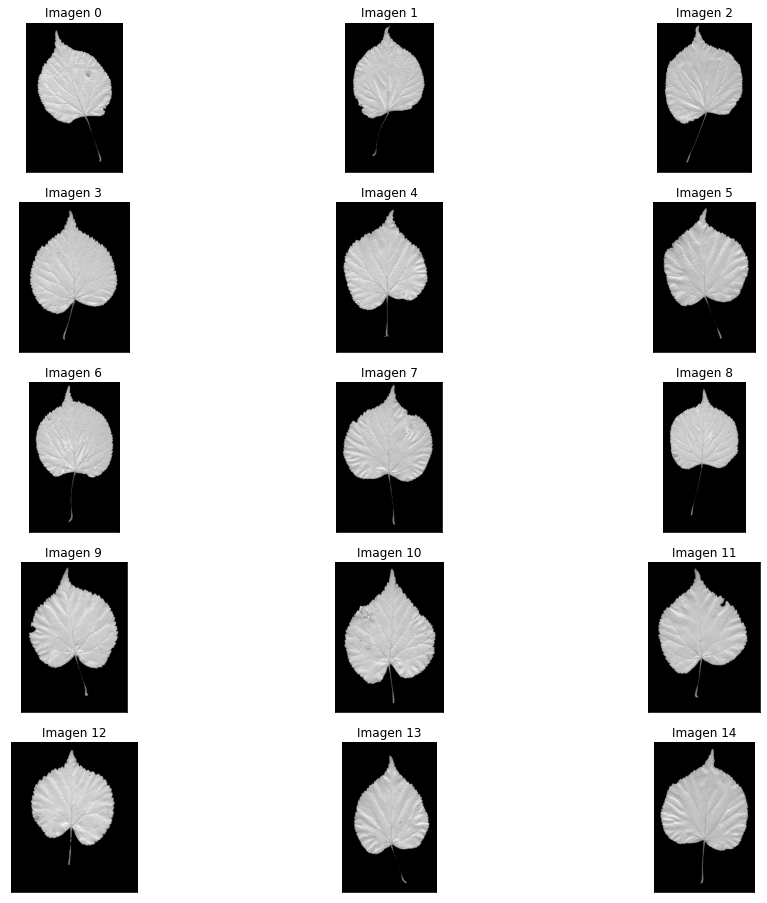

In [150]:
muestraImagenes(test[11,:15],5,3)

## Calcula los superpixeles y el area del LBP

In [16]:
#superpixeles para test
#creamos una copia del array que contiene las imagenes, esta copia contendra los superpixeles
#que seran arrays de las misma dimensiones de las imagenes correspondientes
superpixelTest = np.copy(test)
#hacemos varios ciclos for para calcular los superpixeles de cada imagen de test
#iteramos sobre las clases
for clase in range(test.shape[0]):
    #nos saltamos la clase 9 ya que es problematica al querer considerar los superpixeles conectados
    #para esta clase hacemos un for independiente con los superpixeles no conectados
    #este problema se debe a la morfologia de la flor
    if (clase == 9):
        continue
    #imprimimos el estado actual del ciclo, esto para conocer su progreso
    print('Analizando la clase '+str(clase))
    #iteramos sobre todas las imagenes de una clase dada
    for imagen in range(test.shape[1]):
        #corremos el algoritmo slic sobre la imagen actual
        segmented = slic(test[clase,imagen], n_segments = 10, mask=testBin[clase,imagen],enforce_connectivity=True)
        #en la posicion de la copia de la imagen original colocamos el array de sus superpixeles
        superpixelTest[clase,imagen] = segmented
#este es el ciclo for independiente para la clase 9, aqui solo hay que iterar sobre las imagenes        
for imagen in range(test.shape[1]):
    #imprimimos el estado actual del ciclo, esto para conocer su progreso
    print('Para la clase 9 se analiza la imagen '+str(imagen))
    #corremos el algoritmo slic sobre la imagen actual de la clase 9, note la variable de entrada
    #enforce_connectivity=False seteada en false esto indica que los superpixeles no tienen que
    #forzosamente estar interconectados
    segmented = slic(test[9,imagen], n_segments = 10, mask=testBin[9,imagen],enforce_connectivity=False)
    #en la posicion de la copia de la imagen original colocamos el array de sus superpixeles
    superpixelTest[9,imagen] = segmented
#tiempo aproximado de ejecucion: 15 minutos para 50 segmentos y 80 segmentos de clase 9
#tiempo aproximado de ejecucion: 5 minutos para 5 segmentos y 8 segmentos de clase 9
#tiempo aproximado de ejecucion: 3 minutos para 2 segmentos y 5 segmentos de clase 9

Analizando la clase 0
Analizando la clase 1
Analizando la clase 2
Analizando la clase 3
Analizando la clase 4
Analizando la clase 5
Analizando la clase 6
Analizando la clase 7
Analizando la clase 8
Analizando la clase 10
Analizando la clase 11
Analizando la clase 12
Analizando la clase 13
Analizando la clase 14
Para la clase 9 se analiza la imagen 0
Para la clase 9 se analiza la imagen 1
Para la clase 9 se analiza la imagen 2
Para la clase 9 se analiza la imagen 3
Para la clase 9 se analiza la imagen 4
Para la clase 9 se analiza la imagen 5
Para la clase 9 se analiza la imagen 6
Para la clase 9 se analiza la imagen 7
Para la clase 9 se analiza la imagen 8
Para la clase 9 se analiza la imagen 9
Para la clase 9 se analiza la imagen 10
Para la clase 9 se analiza la imagen 11
Para la clase 9 se analiza la imagen 12
Para la clase 9 se analiza la imagen 13
Para la clase 9 se analiza la imagen 14


In [17]:
#creamos una funcion para calcular el area debajoo del histograma
def areas(imagenes,binarios):
    #lista auxiliar para almacenar las areas segun su clase
    lista = []
    #iteramos sobre todas las clases
    for clase in range(imagenes.shape[0]):
        #lista auxiliar para almacenar las areas segun cada imagen
        auxlist = []
        #llevamos un track del progreso
        print('Analizando clase '+str(clase))
        #iteramos sobre todas las imagenes
        for imagen in range(imagenes.shape[1]):
            #creamos la imagen LBP usando la funcion local_binary_pattern
            #de scikit image, para cada imagen en turno segun el valor de imagen y clase
            LBP = lbp(imagenes[clase,imagen],32,3,method='uniform')
            #calculamos el histograma de la LBP unicamente en la zona definida
            #por los binarios o mascaras binarias, por esa razon se agregan como
            #argumento dichas imagenes. La imagen LBP hay que pasarla a uint8
            #ya que la funcion local_binary_pattern regresa una matriz del tipo float
            #el histograma barre todos los valores posibles de una imagenn en gris
            #de 0 a 255
            histograma = cv2.calcHist([LBP.astype(np.uint8)],[0],binarios[clase,imagen],[256],[0,256])
            #normalizamos el histograma para asegurar una invarianza ante la escala
            histograma = histograma/sum(histograma)
            #usamos suma de Riemman para calcular el area bajo el histograma
            #sin considerar los ultimos dos valores ya que si se hace el area siempre es 1
            #estos valores corresponden a zonas muy parecidas al fondo. Esto lo descubri a traves
            #del codigo de prueba que se encuentra hasta el final de este notebook
            area = sum(histograma[:33])[0]
            #hacemos un append del area recien calculada
            auxlist.append(area)
        #cada vez que termine de calcular las areas de una clase se hace un append a la lista   
        lista.append(auxlist)
    #pasamos a un array de numpy la lista lista
    lista = np.array(lista)
    print('Terminado')
    return lista

In [18]:
#calculamos las areas para las imagenes de test
areasTest = areas(test,testBin)

Analizando clase 0
Analizando clase 1
Analizando clase 2
Analizando clase 3
Analizando clase 4
Analizando clase 5
Analizando clase 6
Analizando clase 7
Analizando clase 8
Analizando clase 9
Analizando clase 10
Analizando clase 11
Analizando clase 12
Analizando clase 13
Analizando clase 14
Terminado


## Entrenamiento a partir del .csv de train


In [51]:
#cargamos los datos de entrenamiento
data = pd.read_csv('texturaTrain10y10.csv')
#dividimos entre variables independientes y variables dependientes
X = data.loc[:,:'area'].to_numpy()
Y = data['clase'].to_numpy()
SVM = SVC(kernel='linear', C=50)
#hacemos un fit usando los datos X e Y
SVM.fit(X,Y)

SVC(C=50, kernel='linear')

## Clasificacion On-line

In [151]:
#creamos una funcion que obtiene los datos de textura a partir de la imagen y sus superpixeles
def clasificacion(imagenes,superpixeles,areas,predictor):
    font= cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (1,150)
    fontScale= 2
    thickness = 2
    fontColor= (255)
    lineType= cv2.LINE_AA
    auxiliarImages = np.copy(imagenes)
    nombres = ['clase 0', 'clase 1', 'clase 2', 'clase 3','clase 4','clase 5','clase 6',
               'clase 7','clase 8','clase 9','clase 10','clase 11','clase 12','clase 13','clase 14']
    for clase in range(imagenes.shape[0]):
        #iteramos sobre las imagenes de cada clase
        for imagen in range(imagenes.shape[1]):
            #calculamos los momentos geometricos de cada imagen segun su clase e imagen en turno
            #estos momentos son necesarios para obtener los momentos de Hu
            moments = cv2.moments(imagenes[clase,imagen])
            #calculamos los momentos de Hu
            huMoments = cv2.HuMoments(moments)
            #Dado que se obtienen 7 valores en un array hay que iterar sobre ellos
            #para poder hacer un escalado de los mismos, ya que las proporciones
            #difieren significativamente entre si
            for i in range(0,7):
                huMoments[i] = np.log(abs(huMoments[i]))
            #iteramos sobre todos los superpixeles de la imagen en turno
            for clasesuperpixel in range(1,np.amax(superpixeles[clase,imagen])+1):
                #creamos lista auxiliar
                predicciones = []
                #buscamos la region del superpixel, como se explico los superpixeles
                #pertenecen a un grupo con una etiqueta
                segment = np.where(superpixeles[clase,imagen]==clasesuperpixel)
                #creamos una imagen auxiliar de puros ceros con las dimensiones de la imagen original
                auximage = np.zeros((imagenes[clase,imagen].shape[0],imagenes[clase,imagen].shape[1]),dtype=np.uint8)
                #en la posicion del superpixel definimos los valores como 1, 0 en otro caso
                auximage[segment] = 1
                #multiplicamos la imagen auxiliar con la imagen, esto para obtener una imagen de fondo
                #negro con unicamente el superpixel en turno
                auximage = auximage*imagenes[clase,imagen]
                #definimos la matriz de coocurrencia
                GLCM = greycomatrix(auximage,distances=[1],angles=[0],symmetric=False,normed=True)
                #dado que la matriz cuenta las vecinos y sabemos que la imagen multiplicada tiene valores de cero
                #debemos quitar las cuentas para los valores de cero. Esto se hace eliminando la primera fila y columna
                GLCM = GLCM[1:,1:,:,:]
                #obtenemos las propiedades de la GLCM
                contrast = greycoprops(GLCM,'contrast')
                dissimilarity = greycoprops(GLCM,'dissimilarity')
                homogeneity = greycoprops(GLCM,'homogeneity')
                asm = greycoprops(GLCM,'ASM')
                energy = greycoprops(GLCM,'energy')
                correlation = greycoprops(GLCM,'correlation')
                #dado que los valores pueden variar en rango aplicamos una transformacion
                #logaritmica para obtener un rango mas pequeño. Esta transformacion actua como
                #un escalador
                contrast = np.log(abs(contrast[0,0]))
                dissimilarity = np.log(abs(dissimilarity[0,0]))
                homogeneity = -1*m.copysign(1.0, homogeneity[0,0])*np.log(abs(homogeneity[0,0]))
                asm = -1*m.copysign(1.0, asm[0,0])*np.log(abs(asm[0,0]))
                energy = -1*m.copysign(1.0, energy[0,0])*np.log(abs(energy[0,0]))
                correlation = correlation[0,0]
                datas = np.array([contrast,dissimilarity,homogeneity,asm,energy,correlation,huMoments[0][0],
                huMoments[1][0],huMoments[2][0],huMoments[3][0],huMoments[4][0],huMoments[5][0],huMoments[6][0],areas[clase,imagen]])
                s = predictor.predict(datas.reshape(1,-1))
                s = s[0]
                predicciones.append(s)
            mostCommon = mode(predicciones)
            cv2.putText(auxiliarImages[clase,imagen],nombres[int(mostCommon)],bottomLeftCornerOfText,font,fontScale,fontColor,thickness,lineType)
    return auxiliarImages

In [152]:
aux = clasificacion(test,superpixelTest,areasTest,SVM)

<function matplotlib.pyplot.show(*args, **kw)>

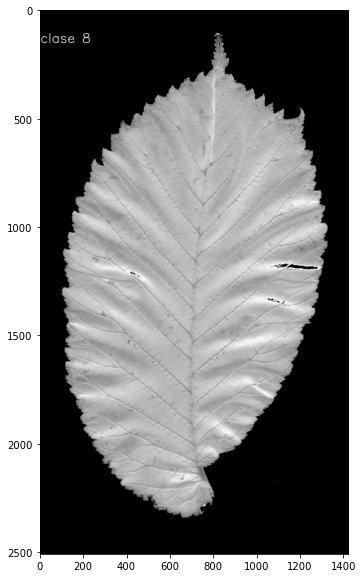

In [153]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(aux[0,0],cmap='gray')
plt.show

In [154]:
#creamos el directorio mascaras si es que no existe
if not os.path.exists('validacion'):
    os.mkdir('validacion')
#iteramos sobre todas las imagenes
for tipo in range(aux.shape[0]):
    for imagen in range(aux.shape[1]):
        #creamos una imagen auxiliar que sera la mascara de la imagen en turno,
        #tal y como se hizo en la celda anterior
        #auxImage = mascaras[tipo,imagen]*listImagesGris[tipo,imagen]
        #definimos el path donde guardaremos cada images
        path = 'validacion/tipo'+str(tipo)+'/'
        #si dicha carpeta en dicho path no existe, entonces creala
        if not os.path.exists(path):
            os.mkdir(path)
        #guarda la imagen en turno en su respectivo path
        cv2.imwrite(path+str(imagen)+'.png', aux[tipo,imagen])